In [34]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
sys.path.append("/Users/kushagra/Documents/personal-repo/NLP/NLP-Exploratorium")

from config import config

# Starting out with RNNs

Recreating examples from Franscois Chollet's for chapter's 10 and 11

Chapter 10 introduces about RNN's and LSTMs whereas chapter 11 is about NLP

In [7]:
df = pd.read_csv(Path(config.DATA_DIR)/'jena_climate_2009_2016.csv')

In [15]:
temperature = df['T (degC)'].values
df = df.drop(columns=['T (degC)', 'Date Time'])

In [17]:
raw_data = df.values

In [26]:
temperature.shape[0]

420451

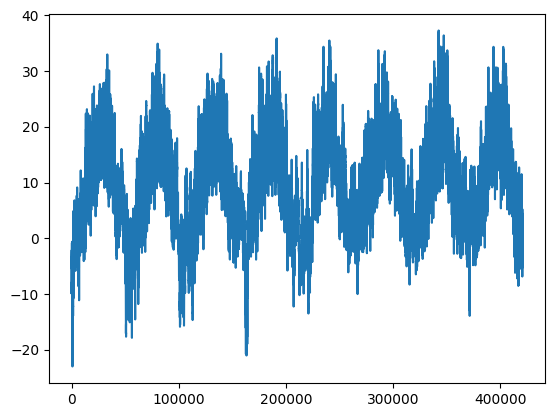

In [29]:
plt.plot(temperature)
plt.show()

In [30]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples

mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean

std = raw_data[:num_train_samples].std(axis=0)
raw_data/=std

## Understanding timeseries_dataset_from_array()

In [43]:
int_sequence = np.arange(10)
dummy_dataset = tf.keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [46]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 -1)
batch_size = 256

## Train, Test and Val datasets

In [75]:
train_dataset = tf.keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples
)

test_dataset = tf.keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples
)

val_dataset = tf.keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples
)